<a href="https://colab.research.google.com/github/alwaysneedhelp/Practice-for-IOAI/blob/main/IOAI_2025_Home_Satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Weather Forecasting

You're a high school student interning at a regional climate lab, working alongside a small team of scientists focused on improving rainfall prediction using only satellite imagery. Traditionally, rain is measured by radar and ground sensors — but these systems are costly and often unavailable in remote regions.

<div align="center">
  <img src="https://drive.google.com/uc?id=1MSTDmcsJbbKScmiggcRaKJStXofrQCF9" alt="Weather Forecasting" width="300" />
</div>

While analyzing GOES-16 satellite images, you come up with an idea:

> "What if we could train a model to detect rain directly from satellite images — even without ground-based data? And what if we used additional context like sun angle, time of day, and location to improve its accuracy?"

The scientists are intrigued. You're given access to a large archive of satellite data and precipitation masks — and one challenge: prove it can work. If successful, your approach could help small farmers in underserved regions plan irrigation more effectively and reduce crop losses.

Your mission: build a model that looks at the sky — and tells us whether it’s going to rain.


## Task

Your task is to develop an AI model that takes satellite imagery from the GOES-16 satellite as the input; and predicts — for each pixel — whether rainfall is occurring at the corresponding location on Earth. This is a **semantic segmentation** task: your model should output a binary mask indicating "rain" or "no rain" at each pixel.

You can train and evaluate your model using ground-truth precipitation data provided by the MRMS (Multi-Radar Multi-Sensor) dataset.

A baseline segmentation model based on a pretrained U-Net is provided to help you get started.

**You ARE allowed to:**
- Fine-tune or modify the baseline U-Net
- Use metadata (e.g., latitude, longitude, time, sun elevation)
- Modify the inference logic (e.g., thresholding, post-processing)

**You are NOT allowed to:**
- Use any external datasets
- Use external pretrained models other than the provided baseline
- Look for the weather-forecasting articles on the internet. While this is a home task, it is intended to prepare you for the on-site contest.

## Data

The dataset includes satellite observations from the year 2024 and includes the following:

- **GOES-16 ABI Multichannel Imagery**  
  16 spectral channels (C01–C16), covering a range of wavelengths:  
  - C01–C03: visible light  
  - C04–C06: near-infrared  
  - C07–C16: infrared  
  Images are cropped into patches of either 128×128 or 256×256 pixels.

- **Precipitation masks** from the MRMS system, providing binary labels (rain/no rain) per pixel.

- **Metadata**, including:  
  - Latitude and longitude of the patch's top-left corner  
  - Start and end time in UTC (capturing all 16 channels takes ~10 minutes)  
  - A Python utility to compute **sun elevation angle** based on time and location


### Train-Validation Split

- The **training set** is biased toward rainy scenes: only patches where at least 3% of pixels contain rain are included.
  
- The **validation set** is designed to reflect real-world conditions: many patches contain little or no rainfall. Additionally, some samples may include transmission issues — for example, certain spectral channels might be deliberately missing or corrupted.


## Evaluation

Your model will be evaluated on two metrics:

- **Mean Dice Score**:  
  Measures how well your predicted mask matches the ground truth, pixel-by-pixel. The Formula is 2 × |intersection| / (|prediction| + |ground_truth|).


- **Image-level Rain Accuracy**:  
  Measures whether your model correctly classifies if any rain is present in the image. This is because sometimes you do not need to segment every drop of rain — it is enough to simply know whether it will rain at all. Even a single accurate prediction can help protect an entire field of crops.

- **Final Score**:
$$
  \text{Final Score} = (\text{Mean Dice Score} + \text{Image-level Rain Accuracy})/2
$$

## Copyright

All data used in this challenge is publicly available:

- **GOES-16 ABI** satellite data from NOAA and NESDIS  
- **MRMS** precipitation data from NOAA's National Severe Storms Laboratory (NSSL)


## Implementation
### Imports

In [3]:
# @title
%pip install --upgrade datasets

In [4]:
# @title
from huggingface_hub import hf_hub_download
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import zipfile
from tqdm import tqdm
from datetime import datetime, timedelta
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

DATASET = hf_hub_download(
    repo_id = "Silicon23/ioai2025-athome-satellite-images",
    filename = "data/dataset.npz",
    repo_type = "dataset"
)
METADATA = hf_hub_download(
    repo_id = "Silicon23/ioai2025-athome-satellite-images",
    filename = "data/metadata.csv",
    repo_type = "dataset"
)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASELINE_MODEL = hf_hub_download(
    repo_id = "Silicon23/ioai2025-athome-satellite-baseline",
    filename = "model_weights.pth"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset.npz:   0%|          | 0.00/541M [00:00<?, ?B/s]

metadata.csv: 0.00B [00:00, ?B/s]

model_weights.pth:   0%|          | 0.00/124M [00:00<?, ?B/s]

### Data Utility Functions

In [5]:
# @title
def pixel_to_latlon(i, j):
    """
    Converts pixel indices (row i, column j) to geographic latitude and longitude.

    Args:
        i (int): Row index (from 0 at the top to 3499 at the bottom).
        j (int): Column index (from 0 at the left to 6999 at the right).

    Returns:
        tuple: (latitude, longitude) as floats.

    This function is used to convert from image/pixel coordinates
    (such as a satellite image) to actual map coordinates.
    """
    lat = 60.0 - i * 0.01   # Each row down is 0.01 degree further south
    lon = -130.0 + j * 0.01 # Each column right is 0.01 degree further east
    return lat, lon


def solar_elevation(x, y, dt_utc):
    """
    Calculates the sun's elevation angle above the horizon for a specific
    location (pixel) and UTC time.

    Args:
        x (int): Row index in the image (vertical position).
        y (int): Column index in the image (horizontal position).
        dt_utc (datetime or str): The date and time in UTC (string or datetime).

    Returns:
        float: Solar elevation angle in degrees.

    This function tells you "how high is the sun in the sky"
    for a given place and time.
    """
    # If time is given as string, convert to datetime
    if isinstance(dt_utc, str):
        dt_utc = datetime.strptime(dt_utc, '%Y-%m-%d %H:%M:%S.%f')

    # Convert pixel indices to latitude and longitude
    lat, lon = pixel_to_latlon(x, y)

    # Estimate local time (in hours) by longitude (15 degrees = 1 hour)
    timezone_offset = lon / 15.0
    local_time = dt_utc.hour + dt_utc.minute / 60 + timezone_offset

    # Day of year (1-365/366)
    N = dt_utc.timetuple().tm_yday

    # Solar declination: angle between sun's rays and Earth's equator
    decl = 23.44 * math.sin(math.radians(360 / 365 * (N - 81)))

    # Hour angle: how far in time from solar noon
    H = 15 * (local_time - 12)  # degrees

    # Convert everything to radians for math functions
    phi = math.radians(lat)
    delta = math.radians(decl)
    H = math.radians(H)

    # Calculate elevation using spherical trigonometry
    sin_h = math.sin(phi) * math.sin(delta) + math.cos(phi) * math.cos(delta) * math.cos(H)
    h = math.degrees(math.asin(sin_h))
    return h


def parse_goes_time(timestr):
    """
    Converts a GOES satellite timestamp string into a Python datetime.

    Args:
        timestr (str): Timestamp string, e.g. 's20242891100205'.

    Returns:
        datetime: The parsed datetime.

    Format explanation:
        - 's20242891100205' means:
            year = 2024,
            day-of-year = 289,
            hour = 11,
            minute = 00,
            second = 20,
            tenths of a second = 5
    """
    year = int(timestr[1:5])
    doy = int(timestr[5:8])
    hour = int(timestr[8:10])
    minute = int(timestr[10:12])
    second = int(timestr[12:14])
    micro = int(timestr[14]) * 100000  # tenths of a second
    return datetime(year, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second, microseconds=micro)


def prepare_dataset(data, threshold=0.1):
    """
    Prepares input (X) and output (Y) tensors from raw patch data,
    applying normalization, thresholding, and cleaning.

    Args:
        data (dict): Dictionary mapping patch size to lists of numpy arrays,
                     each array is [17, D, D] (16 channels + 1 mask channel).
        threshold (float): Threshold for converting last channel to binary mask.

    Returns:
        tuple: (X_dict, Y_dict, norm_stats)
            - X_dict: Dict of input tensors, shape [N, 16, D, D] for each size.
            - Y_dict: Dict of output masks, shape [N, D, D] for each size.
            - norm_stats: Dict with 'mean' and 'std' for normalization (per channel).

    This function does two passes over the data:
        1. Computes mean and std for each input channel (ignoring NaNs).
        2. Normalizes the data and packs it into torch tensors.
    """

    num_channels = 16  # First 16 channels are features, last one is target mask

    # === Pass 1: Compute statistics for normalization ===
    sum_channels = torch.zeros(num_channels, dtype=torch.float64)    # Total sum per channel
    sum_sq_channels = torch.zeros(num_channels, dtype=torch.float64) # Total squared sum per channel
    count_channels = torch.zeros(num_channels, dtype=torch.int64)    # Number of valid (non-NaN) values per channel

    for patches in data.values():
        for arr in patches:
            arr = torch.tensor(arr.squeeze(0), dtype=torch.float32)  # arr: [17, D, D]
            x = arr[:16]  # [16, D, D] - input features
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)  # Replace NaN/inf with 0

            valid = ~torch.isnan(x)  # Mask of valid values
            sum_channels += torch.where(valid, x, torch.tensor(0.0)).sum(dim=(1, 2))
            sum_sq_channels += torch.where(valid, x ** 2, torch.tensor(0.0)).sum(dim=(1, 2))
            count_channels += valid.sum(dim=(1, 2))

    # Compute mean and std per channel
    means = sum_channels / count_channels
    variances = (sum_sq_channels / count_channels) - means ** 2
    stds = torch.sqrt(torch.clamp(variances, min=1e-6))  # avoid sqrt of negative

    # === Make sure no zeros, NaNs or infs in std/mean ===
    stds[stds == 0] = 1.0
    stds[torch.isnan(stds)] = 1.0
    stds[torch.isinf(stds)] = 1.0

    means[torch.isnan(means)] = 0.0
    means[torch.isinf(means)] = 0.0

    norm_stats = {
        "mean": means.to(torch.float32),
        "std": stds.to(torch.float32)
    }

    # === Pass 2: Normalize and pack tensors for PyTorch training ===
    X_dict = {}
    Y_dict = {}

    for size, patches in data.items():
        n = len(patches)    # Number of patches for this size
        D = size            # Patch size (width and height)

        # Allocate memory for all normalized patches and masks
        X_tensor = torch.empty((n, num_channels, D, D), dtype=torch.float16)
        Y_tensor = torch.empty((n, D, D), dtype=torch.uint8)

        for i, arr in enumerate(patches):
            arr = torch.tensor(arr.squeeze(0), dtype=torch.float32)  # [17, D, D]
            x = arr[:16]           # First 16 channels: features
            y = (arr[16] > threshold).to(torch.uint8)  # Last channel: mask, binarized

            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)  # Clean

            # Normalize per channel: (value - mean) / std
            x_norm = ((x - means[:, None, None]) / stds[:, None, None]).to(torch.float16)

            X_tensor[i] = x_norm   # Save normalized input
            Y_tensor[i] = y        # Save output mask

        X_dict[size] = X_tensor
        Y_dict[size] = Y_tensor

    return X_dict, Y_dict, norm_stats

### Model Utility Functions

In [20]:
# @title
class PatchDataset(Dataset):
    """
    Custom PyTorch dataset for image patches and their segmentation masks.

    Args:
        X_tensor (torch.Tensor): Input tensor of image patches, shape [N, 16, D, D]
        Y_tensor (torch.Tensor): Target segmentation masks, shape [N, D, D]

    This class is used to feed data into the neural network during training and testing.
    """
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor  # Input images: shape [num_samples, 16, height, width], float16
        self.Y = Y_tensor  # Target masks: shape [num_samples, height, width], uint8 (0 or 1)

    def __len__(self):
        # Returns number of samples in dataset
        return self.X.shape[0]

    def __getitem__(self, idx):
        """
        Fetch one sample and its mask by index.
        Converts X to float32 and adds a channel to Y (needed for loss).
        """
        x = self.X[idx].to(torch.float32)  # Convert to float32 (needed for the model)
        y = self.Y[idx].unsqueeze(0).to(torch.float32)  # Add a channel, shape [1, D, D]
        return x, y


class UNetSegmentation(nn.Module):
    """
    U-Net neural network for image segmentation.

    Args:
        in_channels (int): Number of input channels (e.g., 16 for your patches)

    The U-Net consists of an encoder (downsampling), a bottleneck (middle),
    and a decoder (upsampling). It is widely used for segmenting images,
    where every pixel needs to be classified (e.g., rain/no rain).
    """
    def __init__(self, in_channels):
        super().__init__()
        # Encoder path ("contracting" path): extracts features, reduces size
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)  # Downsamples by factor of 2

        # Bottleneck (middle part)
        self.mid = self.conv_block(512, 1024)

        # Decoder path ("expanding" path): upscales, combines with encoder outputs
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)  # Upsample
        self.dec4 = self.conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final layer: reduces to 1 output channel per pixel (for binary segmentation)
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Output: logits per pixel

    def conv_block(self, in_ch, out_ch):
        """
        Helper function to build a block of two convolutional layers,
        each followed by BatchNorm and ReLU activation.

        Args:
            in_ch (int): Number of input channels.
            out_ch (int): Number of output channels.
        """
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  # Keeps spatial size the same
            nn.BatchNorm2d(out_ch),                   # Helps training
            nn.ReLU(inplace=True),                    # Non-linearity
            nn.Conv2d(out_ch, out_ch, 3, padding=1),  # Another conv layer
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape [batch, channels, height, width]

        Returns:
            torch.Tensor: Output logits, shape [batch, 1, height, width]
        """
        # Encoder: save outputs for skip connections
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        m = self.mid(self.pool(e4))

        # Decoder: upsample, concatenate with encoder outputs (skip connections), then convolve
        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)  # Output shape: [batch, 1, H, W]


def dice_loss(pred, target, eps=1e-6):
    """
    Computes Dice Loss, which measures overlap between prediction and target.

    Args:
        pred (torch.Tensor): Raw logits from the model, shape [B, 1, H, W]
        target (torch.Tensor): Ground truth masks, shape [B, 1, H, W]
        eps (float): Small number to avoid division by zero.

    Returns:
        torch.Tensor: Dice loss (scalar)
    """
    # Apply sigmoid to logits to get probabilities between 0 and 1
    pred = torch.sigmoid(pred)
    # Intersection and union for each image in the batch
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    # Dice loss = 1 - Dice coefficient (higher is worse)
    return 1 - ((2 * intersection + eps) / (union + eps)).mean()


def train_segmentation(model, train_loaders, val_loaders=None, epochs=10, lr=1e-3, device="cuda"):
    """
    Trains the segmentation model using both BCEWithLogitsLoss and Dice loss.

    Args:
        model (nn.Module): The segmentation model (U-Net).
        train_loaders (dict): Dictionary of DataLoader(s) for different patch sizes.
        val_loaders (dict or None): Not used in this code, can be used for validation.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.
        device (str): 'cuda' for GPU or 'cpu' for CPU.

    During training, for each patch size, the function loops through the data in batches,
    computes the combined loss, and updates the model weights.
    """
    bce_loss = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for logits
    model.to(device)                   # Move model to device (GPU/CPU)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Stochastic Gradient Descent
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    for epoch in range(epochs):
        model.train()  # Set model to training mode (affects layers like BatchNorm, Dropout)
        total_loss = 0.0
        print(f"Epoch {epoch + 1}/{epochs}")

        for size in train_loaders:
            loader = train_loaders[size]
            # Progress bar for this patch size
            pbar = tqdm(loader, desc=f"Training {size}x{size}", leave=False)

            for batch_idx, (x, y) in enumerate(pbar):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()  # Clear previous gradients

                with autocast():
                  logits = model(x)  # [B, 1, H, W]
                  logits_clamped = torch.clamp(logits, -20, 20)  # Clamp values for stability

                # Loss = BCE (pixelwise) + Dice (region overlap)
                loss = bce_loss(logits_clamped, y) + dice_loss(logits_clamped, y)

                if torch.isnan(loss):
                    print(f"❌ Batch {batch_idx}: loss is NaN, skipping")
                else:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scheduler.step(loss.item())
                    scaler.update()
                    total_loss += loss.item()

        print(f"  ✅ Avg epoch loss: {total_loss:.4f}")


def build_dataloaders(X_dict, Y_dict, shuffle=True, regime='train'):
    """
    Builds PyTorch DataLoader objects for different patch sizes.

    Args:
        X_dict (dict): Dict of input tensors for each patch size.
        Y_dict (dict): Dict of label tensors for each patch size.
        shuffle (bool): Whether to shuffle the data (good for training).
        regime (str): Can be 'train' or 'test', not used in code.

    Returns:
        dict: Dictionary of DataLoader objects for each patch size.
    """
    batch_sizes = {128: 32, 256: 16}  # Set batch size for each patch size
    train_loaders = {}
    for size in X_dict:
        ds = PatchDataset(X_dict[size], Y_dict[size])  # Make dataset for this size
        train_loaders[size] = DataLoader(ds, batch_size=batch_sizes[size], shuffle=shuffle)
    return train_loaders


def evaluate_on_test(model, test_loaders, device="cuda", threshold=0.5):
    """
    Evaluates the segmentation model on test data and prints metrics.

    Args:
        model (nn.Module): The trained segmentation model.
        test_loaders (dict): Dictionary of DataLoader(s) for each patch size.
        device (str): 'cuda' for GPU or 'cpu' for CPU.
        threshold (float): Threshold for converting probabilities to binary masks.

    Prints:
        - IoU (Intersection over Union)
        - Dice coefficient
        - Precision
        - Recall
        - Image-level accuracy (if any pixel is detected as "rain" in image)
    Returns:
        float: Average of Dice coefficient and image-level accuracy.
    """
    model.eval()             # Set model to evaluation mode (no dropout/batchnorm update)
    model.to(device)

    total_iou = 0.0          # Intersection over Union accumulator
    total_dice = 0.0         # Dice coefficient accumulator
    total_prec = 0.0         # Precision accumulator
    total_recall = 0.0       # Recall accumulator
    total_batches = 0

    rain_y_true = []         # List for true image-level labels (rain/no rain)
    rain_y_pred = []         # List for predicted image-level labels

    with torch.no_grad():    # No need to compute gradients during evaluation
        for size, loader in test_loaders.items():
            pbar = tqdm(loader, desc=f"Test {size}x{size}", leave=False)
            for x, y in pbar:
                x = x.to(device)
                y = y.to(device)

                logits = model(x)  # [B, 1, H, W]
                probs = torch.sigmoid(logits)        # Probabilities in [0, 1]
                preds = (probs > threshold).float()  # Binary predictions

                # Compute intersection and union for IoU
                intersection = (preds * y).sum(dim=(1, 2, 3))
                union = ((preds + y) > 0).float().sum(dim=(1, 2, 3))
                iou = (intersection / (union + 1e-6)).mean().item()

                # Compute Dice coefficient
                dice = (2 * intersection / (preds.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) + 1e-6)).mean().item()

                # Precision and recall for all pixels
                tp = (preds * y).sum().item()                 # True positives
                fp = (preds * (1 - y)).sum().item()           # False positives
                fn = ((1 - preds) * y).sum().item()           # False negatives

                precision = tp / (tp + fp + 1e-6)
                recall = tp / (tp + fn + 1e-6)

                # Add to totals for averaging
                total_iou += iou
                total_dice += dice
                total_prec += precision
                total_recall += recall
                total_batches += 1

                # For image-level rain/no-rain: True if any pixel is "rain"
                rain_y_true += [(y > 0.5).any(dim=(1,2,3)).cpu()]
                rain_y_pred += [(preds > 0.5).any(dim=(1,2,3)).cpu()]

    if total_batches == 0:
        print("⚠️ No valid batches")
        return

    # Combine image-level labels for accuracy calculation
    rain_y_true = torch.cat(rain_y_true)
    rain_y_pred = torch.cat(rain_y_pred)
    acc = (rain_y_true == rain_y_pred).float().mean().item()

    dice_final = total_dice / total_batches

    print(f"\n📊 Test metrics across all sizes:")
    print(f"  • IoU   : {total_iou / total_batches:.4f}")
    print(f"  • Dice  : {dice_final:.4f}")
    print(f"  • Prec  : {total_prec / total_batches:.4f}")
    print(f"  • Recall: {total_recall / total_batches:.4f}")
    print(f"  • Image-level Rain Acc: {acc:.4f}")
    total_score = (dice_final + acc) / 2
    print(f"Final score: {total_score:.4f}")

    # Return a combined score for leaderboard
    return dice_final, acc, total_score

### Load the Data

In [21]:
# Load from .npz file
loaded = np.load(DATASET)

# Reconstruct dictionaries
X_train = {
    128: torch.from_numpy(loaded['X_train_128']),
    256: torch.from_numpy(loaded['X_train_256']),
}
Y_train = {
    128: torch.from_numpy(loaded['Y_train_128']),
    256: torch.from_numpy(loaded['Y_train_256']),
}
X_test = {
    128: torch.from_numpy(loaded['X_test_128']),
    256: torch.from_numpy(loaded['X_test_256']),
}
Y_test = {
    128: torch.from_numpy(loaded['Y_test_128']),
    256: torch.from_numpy(loaded['Y_test_256']),
}


del loaded

In [22]:
for dx, dname in zip([X_train, Y_train],
                     ['X_train', 'Y_train']
                    ):
    for k, d in dx.items():
        print(dname, k, d.shape)

X_train 128 torch.Size([529, 16, 128, 128])
X_train 256 torch.Size([1713, 16, 256, 256])
Y_train 128 torch.Size([529, 128, 128])
Y_train 256 torch.Size([1713, 256, 256])


In [23]:
sample_ind = 8

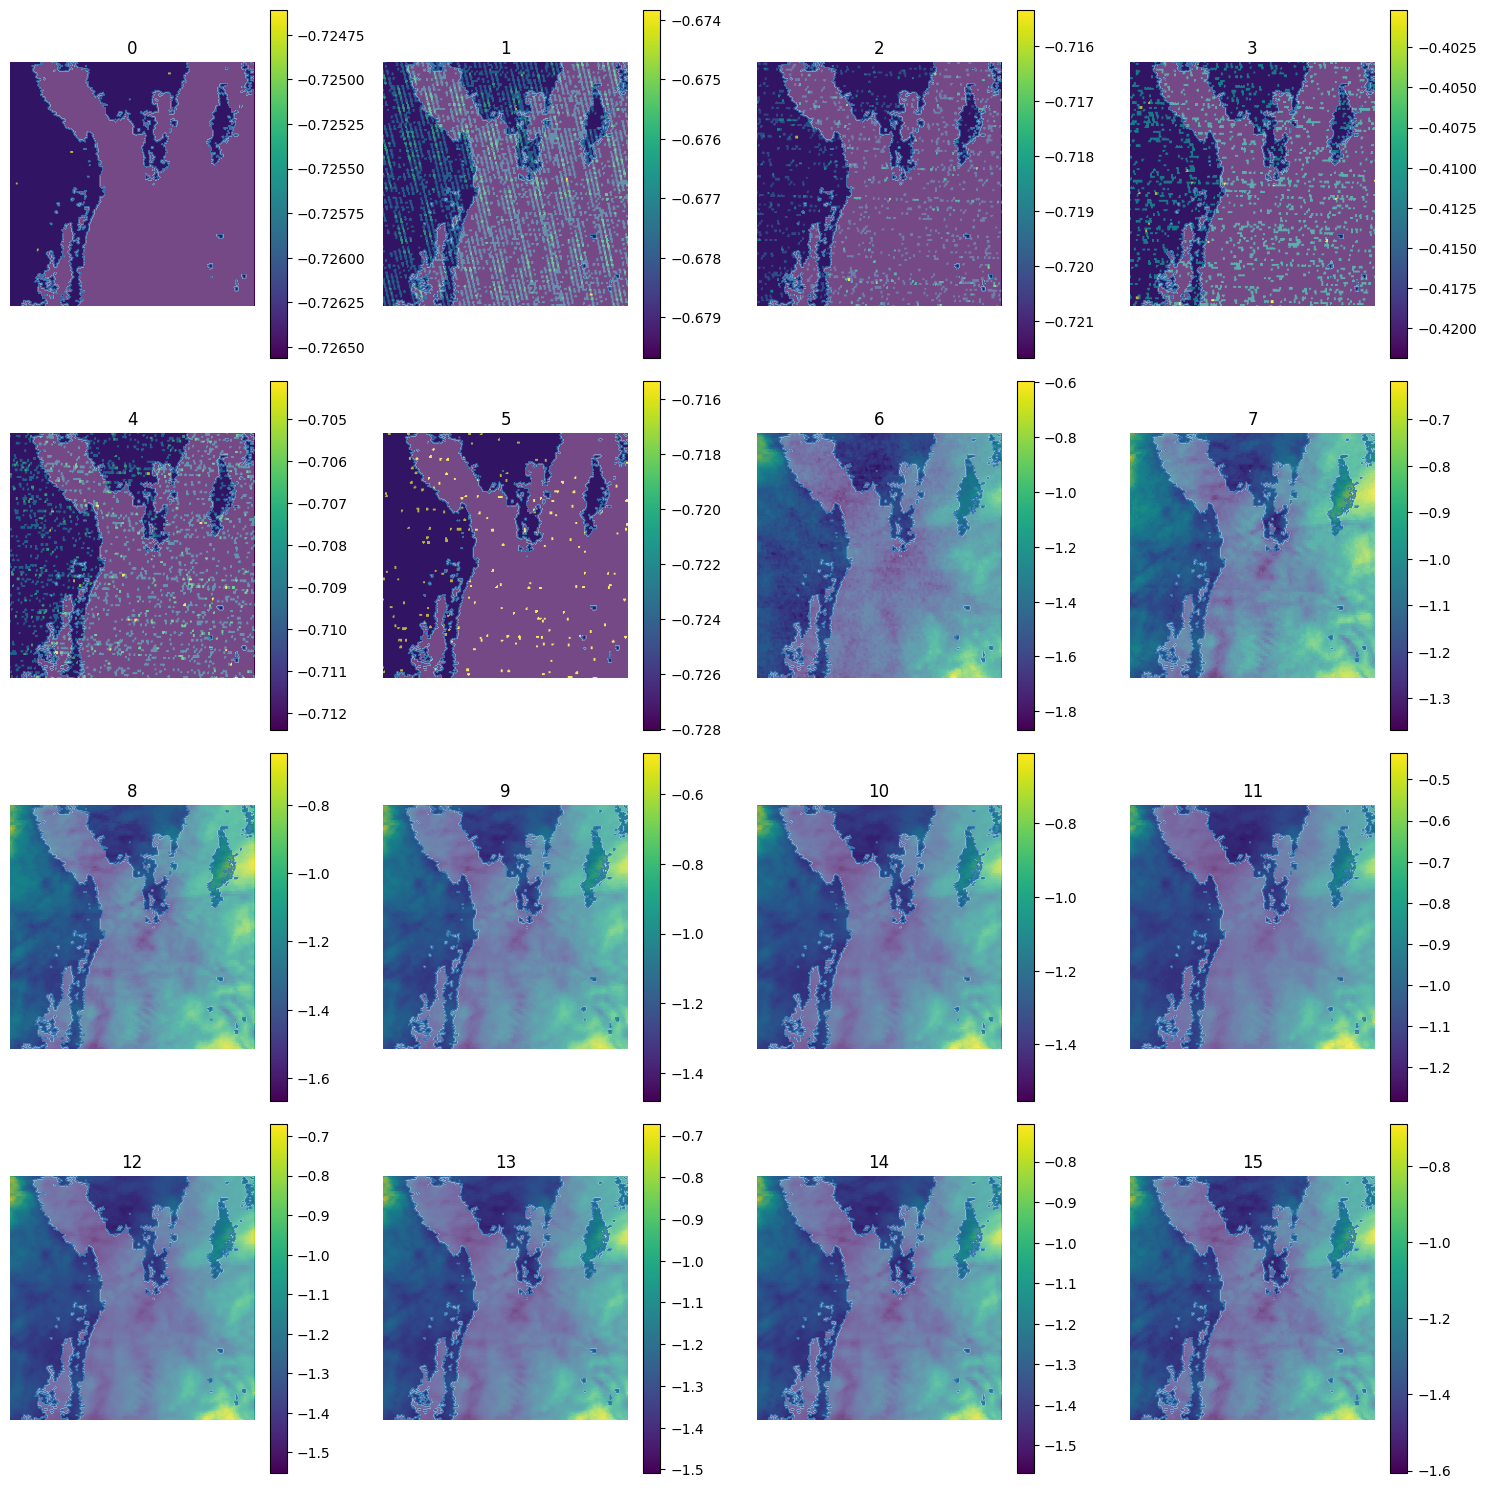

In [24]:
plt.figure(figsize=(15,15))
for ind in range(16):
    plt.subplot(4,4,ind+1)
    plt.imshow(X_train[256][sample_ind, ind, ...])
    plt.colorbar()
    plt.contourf(Y_train[256][sample_ind, ...], cmap='Blues', alpha=.3)
    plt.axis('off')
    plt.title(ind)
plt.tight_layout()

In [25]:
df = pd.read_csv(METADATA)
df

,i,j,size,start_time,end_time,ind,split
0,2917,4877,128,2024-10-15 11:00:20.500,2024-10-15 11:09:52.500,0,train
1,1321,4791,128,2024-05-23 02:00:20.800,2024-05-23 02:09:51.600,1,train
2,1886,1082,128,2024-04-01 05:00:18.900,2024-04-01 05:09:50.300,2,train
3,1941,4046,128,2024-12-14 19:00:20.500,2024-12-14 19:09:51.800,3,train
4,816,3012,128,2024-03-24 14:00:18.800,2024-03-24 14:09:49.600,4,train
...,...,...,...,...,...,...,...
2471,1926,3232,256,2024-08-31 21:00:20.500,2024-08-31 21:09:52.500,178,test
2472,1423,3532,256,2024-06-30 04:00:21.100,2024-06-30 04:09:51.900,179,test
2473,646,2778,256,2024-04-28 11:00:20.700,2024-04-28 11:09:52.200,180,test
2474,683,5465,256,2024-08-28 10:00:20.600,2024-08-28 10:09:51.400,181,test


In [26]:
# to access the metadata of the `sample_ind`th sample of `X_train_128`
i, j, start_time = df[(df['size'] == 128) & (df['split'] == 'train') & (df['ind'] == sample_ind)][['i', 'j', 'start_time']].values[0]
print(df[(df['size'] == 128) & (df['split'] == 'train') & (df['ind'] == sample_ind)].values)

[[752 1332 128 '2024-05-06 10:00:20.700' '2024-05-06 10:09:51.500' 8
  'train']]


In [27]:
solar_elevation(i, j, start_time)  # this means sun is below horison -- you can see it on channels 0-3

-15.060349200646076

### Load the Baseline Model

In [28]:
model = UNetSegmentation(in_channels=16)
model.load_state_dict(torch.load(BASELINE_MODEL, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [29]:
X_train[256][sample_ind:sample_ind+1, ...].to(torch.float32).shape

torch.Size([1, 16, 256, 256])

In [30]:
prediction = model(X_train[256][sample_ind:sample_ind+1, ...].to(torch.float32))
prediction = torch.sigmoid(prediction[0,0,...].detach().cpu()).numpy()

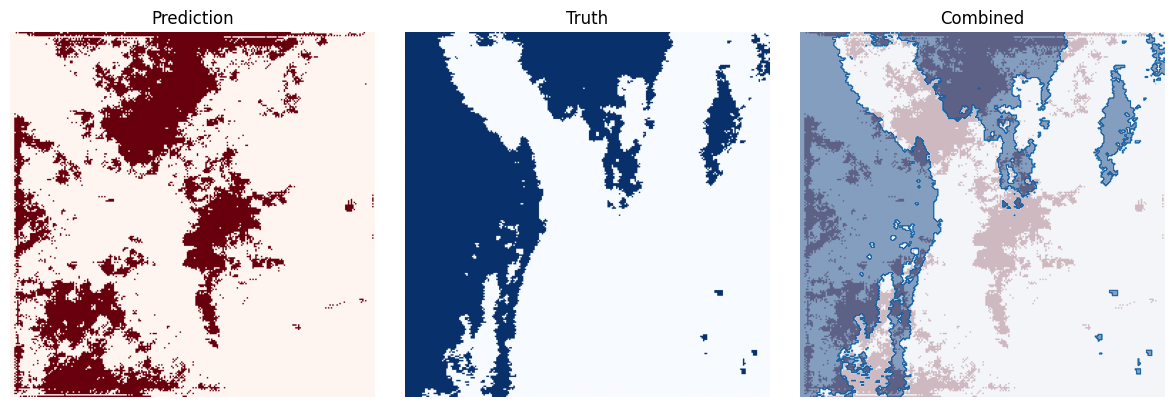

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(prediction > .5, cmap='Reds')
plt.title('Prediction')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(Y_train[256][sample_ind, ...], cmap='Blues')
plt.title('Truth')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Combined')
plt.imshow(prediction > .5, cmap='Reds', alpha=.5)
plt.contourf(Y_train[256][sample_ind, ...], cmap='Blues', alpha=.5)
plt.axis('off')

plt.tight_layout()

### Training

In [1]:
# # you can check model_utils.prepare_dataset to peak on the data preparation
train_loaders = build_dataloaders(X_train, Y_train)
train_segmentation(model, train_loaders, None, lr=1e-3, epochs=1, device=DEVICE)  # change device if it's cuda

NameError: name 'build_dataloaders' is not defined

### Evaluation

Note: you can use a separate model for the image-level (rain/no-rain) classification.

Here, we've provided you with a baseline: just utilize segmentation results for it.


In [ ]:
test_loaders = build_dataloaders(X_test, Y_test)

In [ ]:
dice_val, accuracy, total = evaluate_on_test(model, test_loaders, device=DEVICE)

In [ ]:
total  # your task is to make it larger without peaking on Y_test

### Which channels could help with rain prediction?

- C07, C13–C15 → Show cloud-top temperature — cold tops often mean strong storms

- C08–C10 → Show how much water vapor is in the air

- C04, C05, C06 → Help differentiate cloud types (ice vs. water)

- C11 → Good for identifying cloud phase and dusty conditions

- C16 → Useful for estimating cloud height (important for tall rain clouds)

| Channel | Type       | Wavelength | What it sees / Why it matters                 |
| ------- | ---------- | ---------- | --------------------------------------------- |
| **C01** | Visible    | 0.47 μm    | Blue light: detects smoke, haze, small clouds |
| **C02** | Visible    | 0.64 μm    | Red light: useful for detailed cloud edges    |
| **C03** | Near-IR    | 0.86 μm    | Vegetation, cloud phase, land/water contrast  |
| **C04** | Near-IR    | 1.38 μm    | Thin high clouds (cirrus), upper atmosphere   |
| **C05** | Near-IR    | 1.61 μm    | Snow vs. cloud detection                      |
| **C06** | Near-IR    | 2.25 μm    | Cloud particle size and ice content           |
| **C07** | Infrared   | 3.90 μm    | Fog at night, surface heat                    |
| **C08** | IR (WV)    | 6.19 μm    | Upper-level water vapor                       |
| **C09** | IR (WV)    | 6.95 μm    | Mid-level water vapor                         |
| **C10** | IR (WV)    | 7.34 μm    | Lower-level water vapor                       |
| **C11** | Infrared   | 8.50 μm    | Cloud phase, volcanic ash, dust               |
| **C12** | Infrared   | 9.61 μm    | Ozone detection                               |
| **C13** | IR (Clean) | 10.3 μm    | Clean infrared: cloud tops, clear air         |
| **C14** | Infrared   | 11.2 μm    | Standard IR for cloud-top temperature         |
| **C15** | Infrared   | 12.3 μm    | Dirty window: deeper clouds & water vapor     |
| **C16** | IR (CO₂)   | 13.3 μm    | CO₂ band: used for estimating cloud height    |


## Submission

Your notebook needs to generate a `submission.zip` file containing your predictions on the public testing set `pred_a.npz` and your predictions on the private testing set `pred_b.npz`. Each `.npz` file should contain `Y_pred_128` (shape $51 \times 128 \times 128$) and `Y_pred_256` (shape $183 \times 256 \times 256$), your boolean predictions for each testing set.

In [ ]:
# first generate pred_a.npz

model.eval()
model.to(DEVICE)

Y_pred_128 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[128]))):
        x = X_test[128][i]
        metadata = df[(df['size'] == 128) & (df['split'] == 'test') & (df['ind'] == i)] # sample metadata usage
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_128.append(preds.cpu().detach().numpy())
Y_pred_128 = np.concatenate(Y_pred_128, axis=0)

print(Y_pred_128.shape)

Y_pred_256 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[256]))):
        x = X_test[256][i]
        metadata = df[(df['size'] == 256) & (df['split'] == 'test') & (df['ind'] == i)]
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_256.append(preds.cpu().detach().numpy())
Y_pred_256 = np.concatenate(Y_pred_256, axis=0)

print(Y_pred_256.shape)

# You must name your prediction arrays `Y_pred_128` and `Y_pred_256`, and name the file `pred_a.npz` for the public leaderboard
np.savez('pred_a.npz', Y_pred_128=Y_pred_128, Y_pred_256=Y_pred_256)

In [ ]:
# Your notebook will gain access to the test dataset via the DATA_PATH environment variable after submission.
TEST_PATH = os.environ.get('DATA_PATH', "test")

test = np.load(Path(TEST_PATH) / "X_test.npz") # Read test data from X_test.npz under the provided path

X_test = {
    128: torch.from_numpy(test['X_test_128']),
    256: torch.from_numpy(test['X_test_256']),
} # only X_test will be provided

df_test = pd.read_csv(Path(TEST_PATH) / "metadata_test.csv") # Read metadata from metadata_test.csv under the provided path

In [ ]:
Y_pred_128 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[128]))):
        x = X_test[128][i]
        metadata = df_test[(df_test['size'] == 128) & (df_test['ind'] == i)] # sample metadata usage
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_128.append(preds.cpu().detach().numpy())
Y_pred_128 = np.concatenate(Y_pred_128, axis=0)

print(Y_pred_128.shape)

Y_pred_256 = []
with torch.no_grad():
    for i in tqdm(range(len(X_test[256]))):
        x = X_test[256][i]
        metadata = df_test[(df_test['size'] == 256) & (df_test['ind'] == i)]
        logits = model(x.unsqueeze(0).to(torch.float32).to(DEVICE))
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().squeeze(0)
        Y_pred_256.append(preds.cpu().detach().numpy())
Y_pred_256 = np.concatenate(Y_pred_256, axis=0)

print(Y_pred_256.shape)

# You must name your prediction arrays `Y_pred_128` and `Y_pred_256`, and name the file `pred_b.npz` for private leaderboard
np.savez('pred_b.npz', Y_pred_128=Y_pred_128, Y_pred_256=Y_pred_256)


In [ ]:
# zip `pred_a.npz` and `pred_b.npz` into `submission.zip`
with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('pred_a.npz')
    zipf.write('pred_b.npz')
